<h3>Mapping Short-term Ocean Shoreline Change in North Carolina - 2004 to 2009 Statewide</h3>

**The Data:**

- Shoreline data was sourced from:
The North Carolina Department of Environmental Quality: https://deq.nc.gov/about/divisions/coastal-management/coastal-management-data/spatial-data-maps. DEQ provided shorelines for 1998, 2004, and 2009. 


- Long-Term Ocean shoreline erosion data is from: 
The North Carolina Department of Environmental Quality: https://deq.nc.gov/about/divisions/coastal-management/coastal-management-data/spatial-data-maps. The Department last updated ocean shoreline rates in 2013, using a 2011 shoreline.
Erosion rates for 2013 are computed using the Endpoint Rate Method. 


- Transects used in the Analysis are supplied by the UNC Coastal Studies Institute. Transects are rooted in an offshore baseline, shoreline normal, and are spaced at 50 meter intervals.

- Projection: EPSG: 2264 State Plane North Carolina (U.S. Survey Feet)

<h4>Geography:</h4>

To borrow from Pilkey, "*From Currituck to Calabash*"--all 300-plus miles of North Carolina's ocean coast. 

<h4>Processing:</h4> **Part 1  (Processing the shoreline positions and displacements)**

These results will be sent back to QGIS for mapping.

Initially, placement of the displacement computations will be with the set of points attached to the most recent (in this case 2009) vintage shoreline. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# import each of the transect/shoreline intersections files into individual (for the moment) pandas dataframes:

fpath='/Volumes/Beaker/projects/nc_coastal_erosion/data/decadal_shorelines/intersections/'
f_2004='NC_2004stateSL.csv'
f_2009='NC_2009stateSL.csv'


# x,y,year,transect
cols=['x_04','y_04','year', 'transect']
df_2004 = pd.read_csv(fpath+f_2004, header=0, names=cols )

cols=['x_09','y_09','year', 'transect']
df_2009 = pd.read_csv(fpath+f_2009, header=0, names=cols )

In [34]:
### import the transects themselves to retrieve the EPR values(optional, for now):
fpath='/Volumes/Beaker/projects/nc_coastal_erosion/data/decadal_shorelines/'
f_transects='NC_transects.csv'

cols=['ID','BASELNID','TIMESTMP','AUTOGEN','STARTX','STARTY','ENDX','ENDY','AZIMUTH','POINTCNT','EPR','xRoot','yRoot']

df_transects=pd.read_csv(fpath+f_transects, header=0, names=cols)
df_transects['EPRm']=df_transects.EPR*3.2801


#df_transects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9661 entries, 0 to 9660
Data columns (total 14 columns):
ID          9661 non-null int64
BASELNID    9661 non-null int64
TIMESTMP    9661 non-null object
AUTOGEN     8490 non-null float64
STARTX      9661 non-null float64
STARTY      9661 non-null float64
ENDX        9661 non-null float64
ENDY        9661 non-null float64
AZIMUTH     9661 non-null float64
POINTCNT    9661 non-null int64
EPR         9661 non-null float64
xRoot       9661 non-null int64
yRoot       9661 non-null int64
EPRm        9661 non-null float64
dtypes: float64(8), int64(5), object(1)
memory usage: 1.0+ MB


In [35]:
### join (inner join) the shorelines that will be compared (2004-05; 2005-09; 2009-12; 2012-14; 2004-14):

df_0409 = pd.merge(df_2004, df_2009, on='transect', how='inner').sort_values('transect')

### go ahead and sort the transects too, for consistency (if for no other reason):
df_transects = df_transects.sort_values('ID')

df_transects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9661 entries, 0 to 9660
Data columns (total 14 columns):
ID          9661 non-null int64
BASELNID    9661 non-null int64
TIMESTMP    9661 non-null object
AUTOGEN     8490 non-null float64
STARTX      9661 non-null float64
STARTY      9661 non-null float64
ENDX        9661 non-null float64
ENDY        9661 non-null float64
AZIMUTH     9661 non-null float64
POINTCNT    9661 non-null int64
EPR         9661 non-null float64
xRoot       9661 non-null int64
yRoot       9661 non-null int64
EPRm        9661 non-null float64
dtypes: float64(8), int64(5), object(1)
memory usage: 1.1+ MB


In [36]:
### compute the shoreline displacement [absolute value] and rate [absolute value] for each comparison:

# for displacement:
df_0409['displ_abs'] = ((df_0409.x_09-df_0409.x_04)**2 + (df_0409.y_09-df_0409.y_04)**2)**0.5

# for rate:
df_0409['epr_abs'] = (((df_0409.x_09-df_0409.x_04)**2 + (df_0409.y_09-df_0409.y_04)**2)**0.5)/5.0


In [20]:
### TEST CELL

trans=1

xStart = df_transects[df_transects['ID'] == trans].STARTX.item()   
yStart = df_transects[df_transects['ID'] == trans].STARTY.item()

df_0409.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10073 entries, 2905 to 8988
Data columns (total 9 columns):
x_04         10073 non-null float64
y_04         10073 non-null float64
year_x       10073 non-null int64
transect     10073 non-null int64
x_09         10073 non-null float64
y_09         10073 non-null float64
year_y       10073 non-null float64
displ_abs    10073 non-null float64
epr_abs      10073 non-null float64
dtypes: float64(7), int64(2)
memory usage: 787.0 KB


In [46]:
### function sets the sign for the shoreline change deltas (negative signed if erosion, positive signed if accretion)
# Since the delta (delta_abs) is computed using Euclidean geometry (square root of the sum of the squares) we end
# up with only shoreline displacement magnitude. To recover direction we have to revisit the original differences
# between the shoreline transection intersections.

# df_transect.loc[]
def DetectChangeSign(x1, x2, y1, y2, displ, trans):
    # get the start point coordinates for the transect (point rooted at baseline)
    xStart = df_transects[df_transects['ID'] == trans].xRoot.item()   
    yStart = df_transects[df_transects['ID'] == trans].yRoot.item()

    # del1, x1,y1 refers to the older of the two shorelines being compared with the baseline
    # del2, x2,y2 refers to the more recent of the two shorelines being compared with the baseline
    del1=((xStart-x1)**2 + (yStart-y1)**2)**0.5
    del2=((xStart-x2)**2 + (yStart-y2)**2)**0.5
    
    # if older shoreline is closer to the baseline than the more recent shoreline, then the older shoreline is
    # seaward the more recent and so the shoreline at this transect intersection has experience erosion over the
    # time period t (so the displacement and epr **are** negated). If, on the otherhand, the older shoreline is further from the seaward located baseline than
    # the more recent then the older shoreline landward of the more recent, and so net accretion has occurred 
    # at this transect location (so the dislacement and epr ***are not*** negated).
    if(del1 - del2) < 0:  #yes, then erosion (-)
        return(displ * -1.0)
    else:
        return(displ)

    
# for displacement:
df_0409['displ']=df_0409.apply(lambda x: DetectChangeSign( x['x_04'], x['x_09'], x['y_04'], x['y_09'], x['displ_abs'], x['transect'] ), axis=1 )

# for rate:
df_0409['epr']=df_0409.apply(lambda x: DetectChangeSign( x['x_04'], x['x_09'], x['y_04'], x['y_09'], x['epr_abs'], x['transect'] ), axis=1 )


In [47]:
# add status field (identifies shoreline at transect location as either: ACCRETING, ERODING, or NO CHANGE based on
# the sign of the displacement and/or epr) to df_

df_0409.loc[df_0409['displ'] >= 0.5, 'status'] = 'Accreting'
df_0409.loc[df_0409['displ'] <= -0.5, 'status'] = 'Eroding'
#df_0409.loc[df_0409['displ'] > -0.5 and df_0409['displ'] < 0.5, 'status'] = 'No Change'

In [48]:
trans=534
df_0409[df_0409['transect'] == trans]   #.xRoot.item()

,x_04,y_04,year_x,transect,x_09,y_09,year_y,displ_abs,epr_abs,displ,epr,status
2445,2.998623e+06,551953.334855,2004,534,2.998613e+06,551977.713455,2009.0,26.409693,5.281939,-26.409693,-5.281939,Eroding


In [51]:
# compute displacement mapping point set for the 2004-2009 DENR shorelines:
# Let the displacements between the two vintages "ride" on the 2009 instersection points

# append (.join) the df_2009.displ values onto the df_2009 dataframe and then export to ASCII CSV to its 
# return trip to QGIS:
#df_ = df_2009.join([df_0409['displ'],df_0409['epr']])


# finally, export df_:
df_0409.to_csv(fpath+'NC_0409stateSL.csv', header=['x04','y04','xyr','transect','yyr','x09','y09','displ_abs','epr_abs','displ','epr','status'])
#df_

<h4>Now, let's do some plotting...</h4>'''

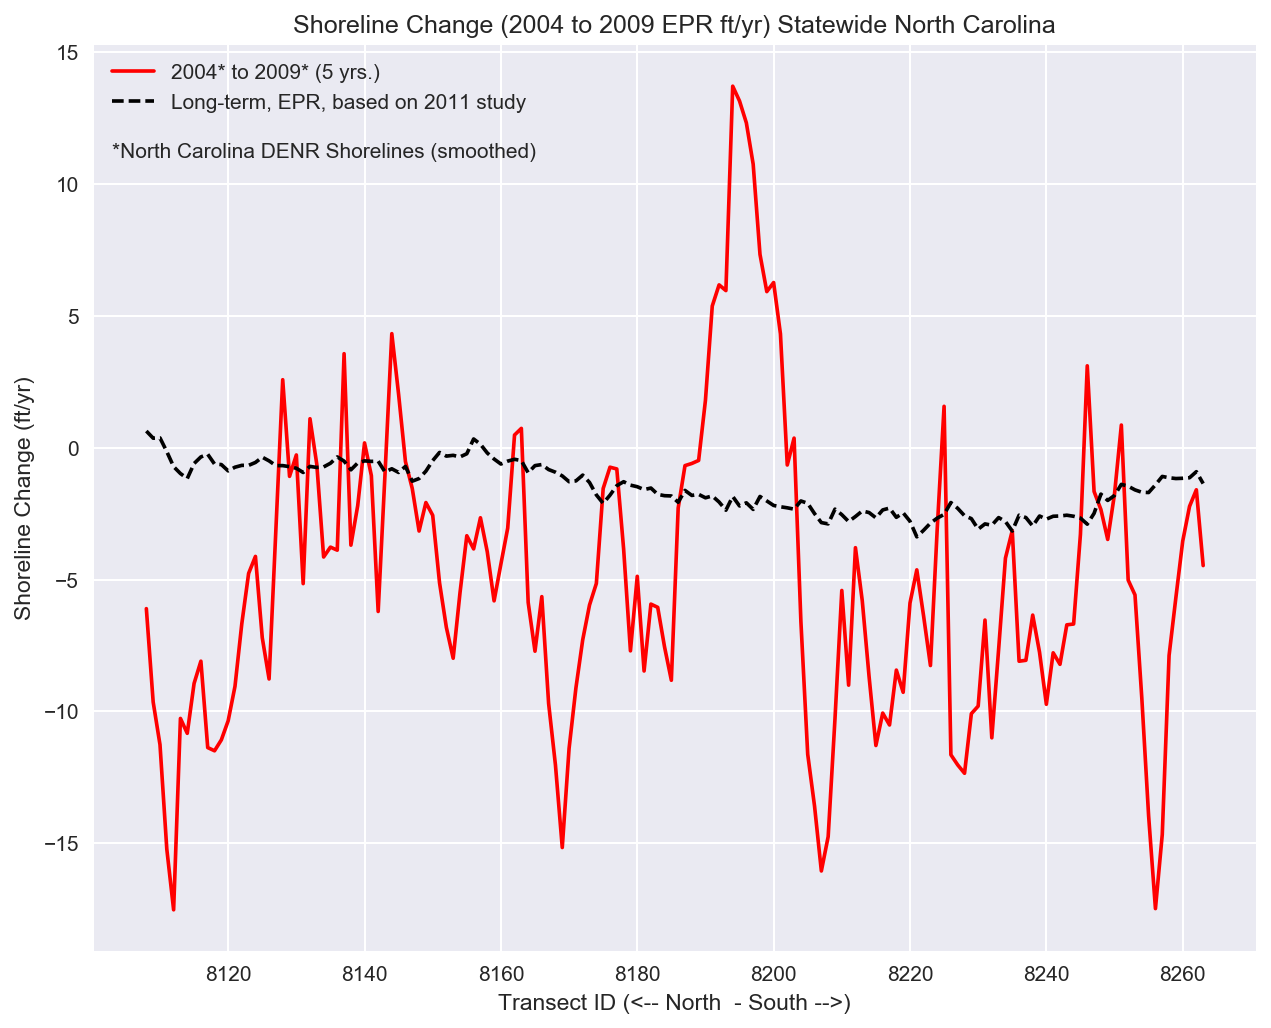

In [18]:
# plot the End Point Rates for the shoreline pairs:

plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')

plt.plot(df_0409.transect, df_0409.epr, c='red', label='2004* to 2009* (5 yrs.)')
plt.plot(df_transects.ID, df_transects.EPR, linestyle='dashed', c='k', label='Long-term, EPR, based on 2011 study')
plt.xlabel('Transect ID (<-- North  - South -->)')
plt.ylabel('Shoreline Change (ft/yr)')
plt.title('Shoreline Change (2004 to 2009 EPR ft/yr) Statewide North Carolina')
plt.text(8103,11, '*North Carolina DENR Shorelines (smoothed)')
plt.legend(loc='upper left')

#plt.savefig('/Volumes/Beaker/projects/nc_coastal_erosion/misc/2004_09_shoreline_erosionrate_NC.pdf')

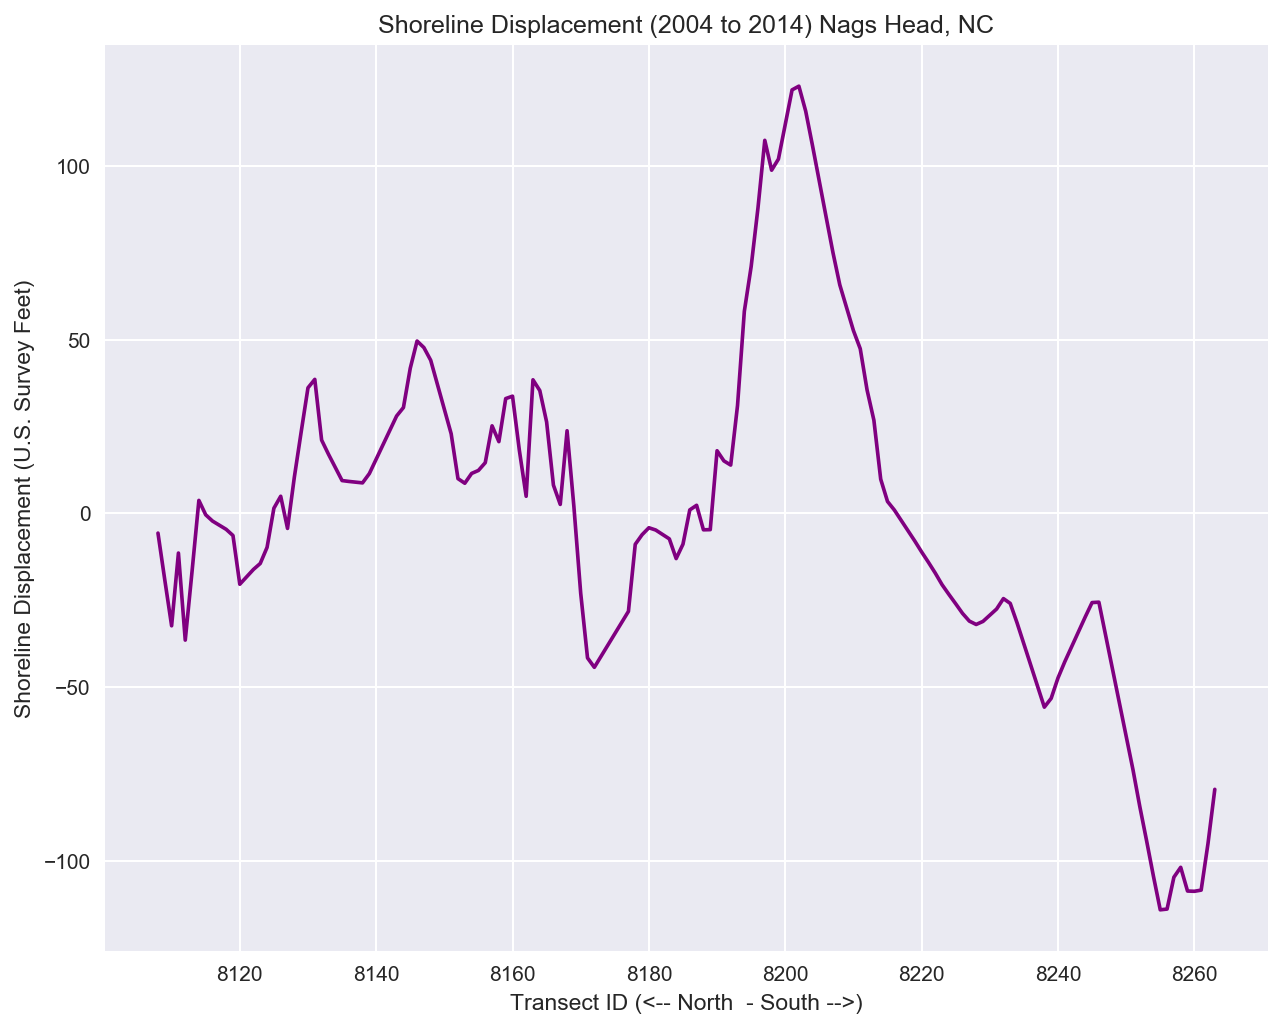

In [48]:
# plot the net decadal displacement alone for the 2004 - 2014 shoreline pair:

plt.figure(num=None, figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')
plt.plot(df_0414.transect, df_0414.displ, c='purple', linestyle='solid', label='2004 to 2014')
#plt.plot(df_transects.ID, df_transects.EPR, linestyle='dashed', c='k', label='Long-term, EPR, based on 2011 study')
plt.xlabel('Transect ID (<-- North  - South -->)')
plt.ylabel('Shoreline Displacement (U.S. Survey Feet)')
plt.title('Shoreline Displacement (2004 to 2014) Nags Head, NC')
#plt.legend(loc='upper left')

plt.savefig('/Volumes/Beaker/projects/nc_coastal_erosion/misc/decade_shoreline_decadedisplacement_NH.pdf')

In [70]:
from mpl_toolkits.basemap import Basemap

map = Basemap(w=, h=, epsg=2264)
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral', lake_color='aqua')
map.drawcoastlines()

map.readshapefile('/Volumes/Beaker/projects/nc_coastal_erosion/NC_0409stateSL', 'NC_0409stateSL')



ValueError: must either specify lat/lon values of corners (llcrnrlon,llcrnrlat,ucrnrlon,urcrnrlat) in degrees or width and height in meters